In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>

# Traits and Range Shifts <small>work by [Tony Cannistra](http://www.github.com/acannistra) and the [Buckley Lab](http://faculty.washington.edu/lbuckley) at the University of Washington</small>

We are attempting to understand the type and magnitude of the effects that various physiological or behavioral traits have had on historical range shifts.

The challenge is that standard linear regression has been only able to explain a small percentage of the variance seen in range shift data for several taxa ([Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract)). This is likely as a result of the relationships between predictor and response variables being something other than linear, especially since several variables have biological relevance for their ability to facilitate range shifts. 

This document proceeds in 3 parts. First we establish an evaluation framework which we can use to compare various methods of elucidating the relationships between various predictors and range shifts. We next bring in some statistical analyses to assist in selecting the set of predictors most likely to influence our response variable. Finally we present a selection of regression techniques and evaluate them on their ability to recover range shift information. 

## Part 1: Evaluation Techniques

### Cross Validation 

For some regression techinques outlined below, it is possible to use the coefficient of determination ($R^2$) to evaluate an algorithms regression performance in terms of explained variance. The use of $R^2$ is problematic in several ways though, namely that a high value does not indicate a model with high predictive power, especially when many of the techniques herein are prone to over-fitting. For most of the techniques presented here we will use **cross validation** to examine the regressor's ability to predict range shifts. 

Cross validation is a nice method for doing feature/parameter selection and also for selecting degrees of freedom in nonparametric models––we'll need both here. 

The Python module [`scikit-learn`]() presents a wealth of cross-validation tools which we include below, namely:
* [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) which computes a random split into testing and training sets
* [`LeaveOneOut`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) more efficiently uses the data as it creates $n$ training and test sets, where the test sets contain only a single element
* `LeavePOut` which is the same as `LeaveOneOut`, except that the number to leave out of the training set can be specified. 

In [22]:
from sklearn.model_selection import train_test_split,\
                                    LeaveOneOut,\
                                    LeavePOut\

### Aikake's Information Criterion (AIC) 
The AIC is defined as $$AIC = -2 \log \mathcal{L} + 2p$$ where $\mathcal{L}$ is the maximized likelihood using **all available** data for estimtion and $p$ is the number of free parameters in the model. *Minimizing AIC is equivalent to minimizing CV value in the asymptote* and this is true for all models [(Stone 1977)](http://www.jstor.org/stable/2984877), not just linear ones. This makes AIC useful in comparing models. It will take some work to create this metric for some of our models, but we will work on it. 

---
## Part 2: Playing with the Data

The next step here is to get a better idea of what the data look like. Much of this work has already been done and is replicated here. The original work can be seen in the [`./experiments`](./experiments) folder and in the [`Statistical Analysis (Alpine Plants).ipynb`]() file (<small>if you're running this notebook on your computer, those links will work. </small>). All important parts are here, though. 

*A note on the data*: These data come from [Angert et al., 2011](http://onlinelibrary.wiley.com/doi/10.1111/j.1461-0248.2011.01620.x/abstract). They contain various trait information for North American birds, Yosemite mammals, Swiss Alpine plants, and dragonflies. By far the largest and most trait-rich data set is the Swiss Alpine plants dataset, so we begin there. 

First we load the data and perform several transformations. Notably, we:

1. Drop features with direct relationship to modeled variable `migration_m` (see `drop_features`)
2. Convert categorical features into [one-hot encoding](http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/). We must do this because although the data set already has converted certain categorical features into an encoding, the ordered encoding used (i.e. 1 = gravity, 2= wind for dispersal) gives arbitrary ordering to the data. This cannot be. We use one-hot encoding to alleviate this. 
3. We can choose whether to filter the data based on significance (the `signif_shift` field), but there's no documentation for that field so we forego that for now
4. Drop features with N/A or NaN (**we lose a good number of features this way**)

In [46]:
DROP_FEATS = 0 # 0 no, 1 yes. 0 = drop rows with N/A. 1 = drop columns with N/A

plants_master = pd.read_csv("../data/plants5.csv")


drop_features = ["Taxon",
                 "migr_sterr_m", 
                 "shift + 2SE", 
                 'signif_shift',
                 "signif_shift2",
                 "dispmode01",
                 "DispModeEng", ## what is this
                 "shift + 2SE",
                ]

categorical_features = ["oceanity",
                        "dispersal_mode",
                        "BreedSysCode",
                        "Grime"]

# one-hot encoding for categorical features:
plants = pd.get_dummies(plants_master, columns=categorical_features)

# drop features we don't want
features = plants.drop(drop_features, axis=1)

# drop features with n/a or NaN
beforenona = set(features.columns.values)
## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
features = features.dropna(axis=DROP_FEATS)
afternona  = set(features.columns.values)

# extract response variable from trimmed data
target   = features["migration_m"]
features.drop(["migration_m"], inplace=True, axis=1)

print("Processing complete:")
print("Number of Entries: " + str(len(features)))
print("Cols removed: " + str((beforenona-afternona)))
print("# Rows Removed: " + str(len(plants_master) - len(features)))

Processing complete:
Number of Entries: 20
Cols removed: set()
# Rows Removed: 113


We also normalize the data for analysis. 

In [44]:
scaler = StandardScaler().fit(features)
features_scaled = scaler.transform(features)


### Are the traits linear? 
Here we're interested in the linear relationships between all of the predictors in the dataset and all of the predictors and the target variable. 


### Plots
we plot the features versus the target variable `migration_m`

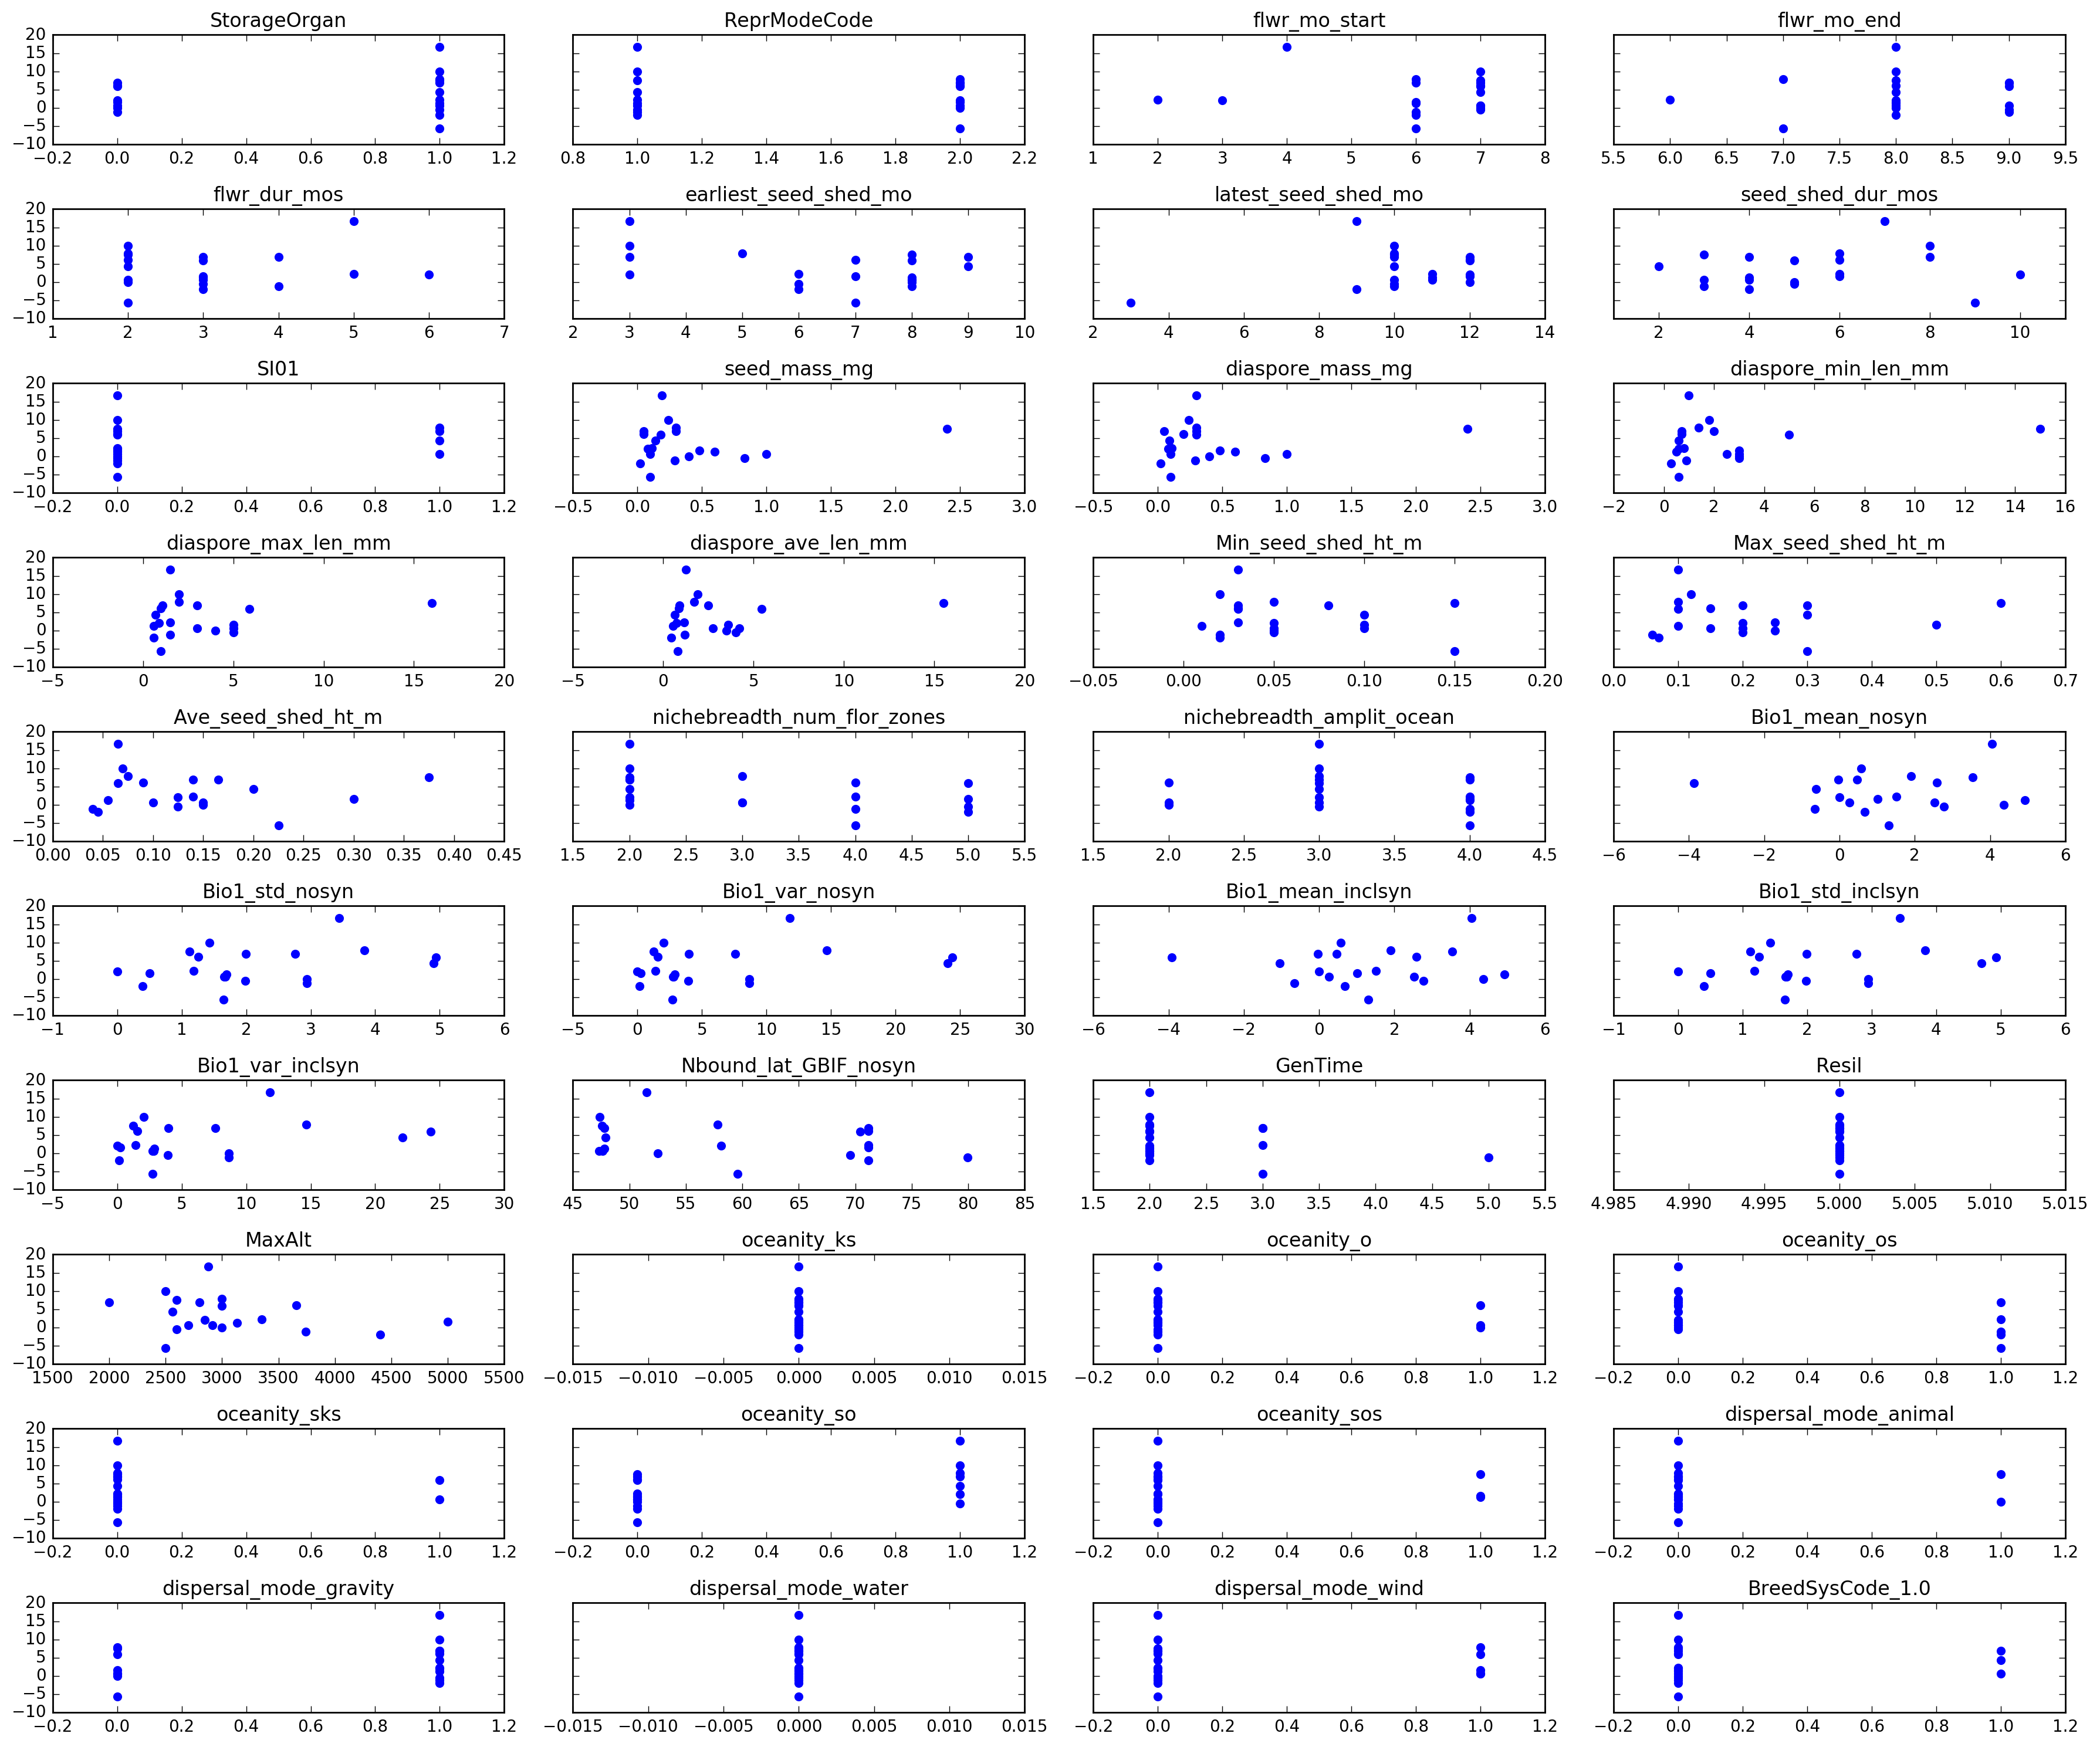

In [47]:
fig, subplots = plt.subplots(10,4, sharey=True)
fig.set_figwidth(18)
fig.set_figheight(15)
featureIter = iter(features.columns)

for row in range(0, 10):
    for col in range(0, 4):
        try:
            feat = next(featureIter)
            X = features[feat].values.reshape(-1,1)
            Y = target
            subplots[row, col].scatter(X, Y, color='blue')
            subplots[row, col].set_title(str(feat))
        except StopIteration:
            fig.delaxes(subplots[row,col])
                    

plt.tight_layout()
plt.show()

These plots show that several of the features (`Bio1_mean_nosyn`, `Bio1_var_inclsyn`, `Ave_seed_shed_ht_m`, etc.) could potentially have linear relationships with the target variable, and that many of the variables are either quite nonlinear in their relationships (`Seed_mass_mg`, `diaspore_min_len_mm`) or are categorical.

Taking a more rigorous approach here, we calculate Pearson's correlation coefficient both for all pairs of features (to assess collinearity) and for each feature and the target migration variable. 

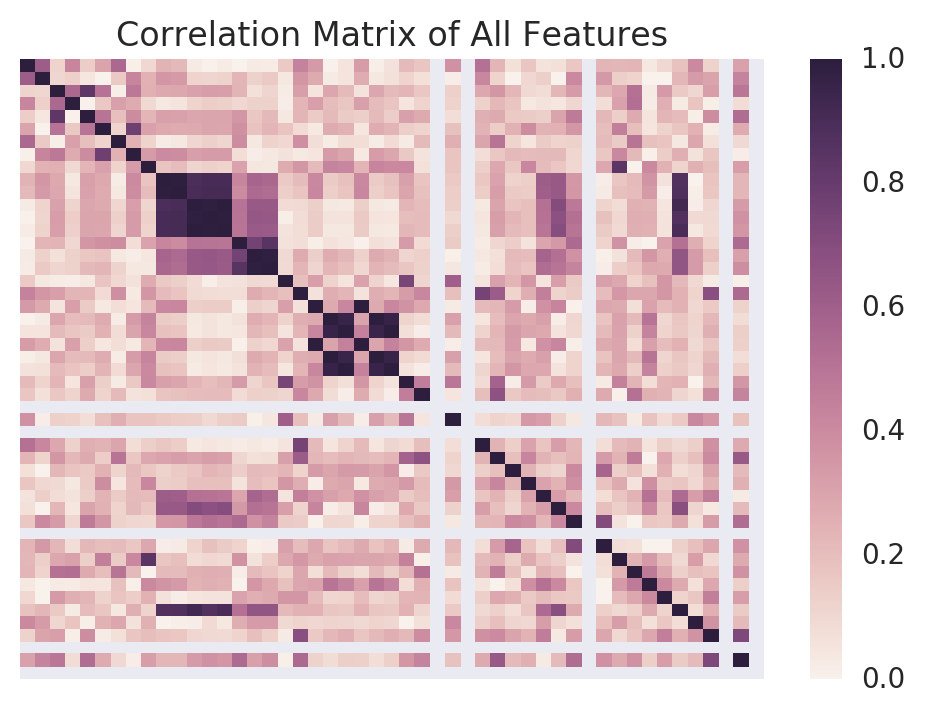

In [107]:
hm = sns.heatmap(features.corr().abs())
hm.set(xticklabels=[], yticklabels=[])
hm.set_title("Correlation Matrix of All Features")


The above correlation plot indicates that many of the features covary to significant degrees. This is a challenging problem to overcome for linear regression. 




<img src="http://faculty.washington.edu/lbuckley/wordpress/wp-content/uploads/2013/05/BuckleyLab_small1.png" width=250px>